## **integrated function**

In [20]:
# import libraries
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy.optimize import fsolve
intersection_point = (0, 0)  # default value

# @parameters for blades
# cutting speed of blade
v_cut_2 = 6 # m2/hr
# life time of blade
a_max_cut_blade = 30 # m^2 for 6-8 m2/hr or 15 m^2 for 3-4 m2/hr
span_blade = a_max_cut_blade/v_cut_2  # = 5hr 
# diameter of blade
d_blade = 0.8 # m (600 mm … 1,600 mm)
# thickness of blade
t_blade = 2.2/1000 # m
# weight of blade
w_blade = np.pi * np.square(d_blade/2) * t_blade * 7800 # kg (steel density 7800 kg/m3)

# @parameters for materials 
# density of materials
rho_light_reinforced_concrete = 2500
rho_hard_reinforced_concrete = 2770
rho_brick =900
rho_concrete = 2150 # kg/m3 lean concrete

# CO2 emission of materials
light_reinforced_concrete_emission = 0.204
hard_reinforced_concrete_emission = 0.358
brick_emission = 0.267
concrete_emission = 0.063 # kgCO2eq/kg from KBOB for Switzerland
steel_CO2_emission = 2.79 # kgCO2eq/kg from KBOB 06.010 Sheet steel, blank, hot rolled, uncoated, thickness 3 mm
electricity_CO2_emission = 0.01057 # 0.01057285 # kgCO2eq/kWh from KBOB for Switzerland
# https://ieeexplore.ieee.org/document/10021341
diamond_blade_CO2_emission = 334.123/200/35 * span_blade * 80 # kgCO2eq/kg
machine_CO2_emission = 0.5 # kgCO2eq/kg assumed average emission for machine production

# @wall saw parameters
# power = 20 # kW, Hilti wall saw DST 20-CA 
power = 32 # kW, Hilti wall saw DST 20-CA (or 40kVA generator using diesel fuel which is around 32kW)
# weight of machine
w_machine = 32 # kg

# @parameters for cutting
fast_cut_speed_area = 6 # m2/hour
slow_cut_speed_area = 3 # m2/hour
cutting_speed = 2-(2-0.7)/(15-5)*(12-5) # 1.08m/min @ 12cm depth

# dimensional parameters
cutting_length = beam_width = 0.4 # meters
cutting_depth = beam_depth = 0.4
beam_length = 4  # meters

# @transportation parameters
distance_factory_b = 100 # km
# the reuse distance is a times the distance from factory to site
a = 2 
distance_a_storage_b_total = a * distance_factory_b # km
# carbon emission of different transportation methods
lorry_CO2_emission = 0.144 # kgCO2eq/tonkm
truck_CO2_emission = 0.183 # kgCO2eq/tonkm, 16-32 ton truck, assuming 8m3 of concrete of 32 ton
# load capacity of lorry or concrete truck
size_truck = 9 # m3
weight_concrete_truck = size_truck * rho_concrete # 19.35 ton
lorry_capacity = 12e3 # ton

# max cutting depth 73 cm
# guide cut at half power consumption at 4cm depth

In [21]:
# calculate the total weight of concrete beam to be transported for reuse
def total_weight_concrete_beam(beam_length, rho):
    weight_concrete_beam = beam_length * beam_width * beam_depth * rho
    max_num_concrete_beam = np.floor(lorry_capacity / weight_concrete_beam) # 7 beams
    total_weight_concrete_beam = max_num_concrete_beam * weight_concrete_beam
    # total_volume_concrete_beam = max_num_concrete_beam * beam_length * beam_width * beam_depth # 4.48 m3 smaller than size limit of lorry
    return total_weight_concrete_beam

# calculate the carbon emission for manufacturing the concrete beam
def manufacturing_cost_beam(carbon_emission, beam_length, beam_width, beam_depth, rho):
    beam_volumne = beam_length * beam_width * beam_depth
    manufacturing_CO2_cost = carbon_emission * beam_volumne * rho
    return manufacturing_CO2_cost

# calculate the carbon emission for manufacturing the concrete wall
def manufacturing_cost_wall(carbon_emission, wall_thickness, wall_width, wall_height, rho):
    wall_volume = wall_thickness * wall_width * wall_height
    manufacturing_CO2_cost = carbon_emission * wall_volume * rho
    return manufacturing_CO2_cost

# calculate the carbon emission for cutting the concrete beam
def cut_impact(electricity_CO2_emission, cutting_time):
    impact_energy = (power * cutting_time) * (electricity_CO2_emission) # impact of electricity consumption 
    impact_blade = diamond_blade_CO2_emission * cutting_time /span_blade
    # impact_blade = (w_blade * cutting_time /span_blade) * steel_CO2_emission + (w_diamond * cutting_time /span_blade) * diamond_CO2_emission# impact of blade production
    impact_machine = w_machine * machine_CO2_emission # impact of machine production
    cut_impact = impact_energy + impact_blade + impact_machine
    return cut_impact

# calculate the cutting time for the concrete beam
def cutting_time_beam(cutting_length, cutting_depth, cut_speed_area):
    cutting_pass = np.ceil(cutting_depth/0.12) * 2 # back and forth cut @12cm depth
    cutting_time_speed = 2 * (cutting_length /cutting_speed * cutting_pass + cutting_length/(cutting_speed/2))/60 # hours # two cuts
    cutting_time_area = 2 * ( cutting_length * cutting_depth/ cut_speed_area * cutting_pass  + cutting_length/(cutting_speed/2)/60)
    return max(cutting_time_speed, cutting_time_area)

# calculate the cutting time for the concrete wall
def cutting_time_wall(wall_width, wall_height, wall_thickness, cut_speed_area):
    cutting_length = 2*(wall_width+wall_height)
    cutting_depth = wall_thickness
    # number of passes
    cutting_pass = np.ceil(cutting_depth/0.12) * 2 # back and forth cut @12cm depth
    # cutting time depending on speed or area
    cutting_time_speed = 2 * (cutting_length /cutting_speed * cutting_pass + cutting_length/(cutting_speed/2))/60 # hours # two cuts
    cutting_time_area = 2 * ( cutting_length * cutting_depth/ cut_speed_area * cutting_pass  + cutting_length/(cutting_speed/2)/60)  
    return max(cutting_time_speed, cutting_time_area)

# calculate the carbon emission for transportation of reused concrete beam
def transport_impact_lorry(total_weight_concrete_beam,distance_a_storage_b_total): # assume fully loaded lorry
    transport_impact_lorry = distance_a_storage_b_total * total_weight_concrete_beam/1000 * lorry_CO2_emission
    return transport_impact_lorry

# calculate the carbon emission for transportation of new concrete
def transport_impact_truck(distance_factory_b,weight_concrete_truck):
    concrete_truck_transport = distance_factory_b * weight_concrete_truck/1000 * truck_CO2_emission 
    transport_impact_truck = concrete_truck_transport * truck_CO2_emission
    return transport_impact_truck

In [10]:
# test of cutting concrete beams of length 4m, width 0.4m, depth 0.4m
weight_concrete_beam = beam_length * beam_width * beam_depth * rho_light_reinforced_concrete
max_num_concrete_beam = np.floor(lorry_capacity / weight_concrete_beam) 
cutting_time = cutting_time_beam(beam_width, beam_depth, fast_cut_speed_area)
reuse_impact = transport_impact_lorry(total_weight_concrete_beam,distance_a_storage_b_total)\
            + cut_impact(electricity_CO2_emission, cutting_time) * max_num_concrete_beam 
new_impact = transport_impact_truck(distance_factory_b,weight_concrete_truck) \
        + manufacturing_cost_beam(light_reinforced_concrete_emission, beam_length, beam_width, beam_depth, rho_light_reinforced_concrete) 
reuse_impact, new_impact

(550.15389535505, 391.20121500000005)

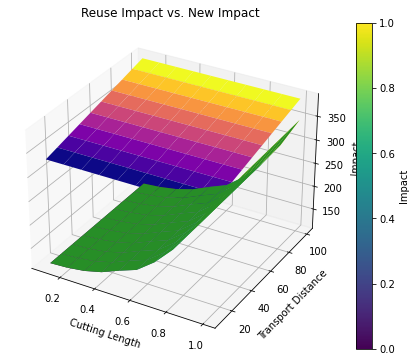

In [14]:
# plot with Matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Define the range of cutting length and transport distance
cutting_length_range = np.linspace(0.1, 1.0, 10)  # Example range for cutting length
transport_distance_range = np.linspace(10, 100, 10)  # Example range for transport distance

# Create 2D grids of cutting length and transport distance
cutting_length_grid, transport_distance_grid = np.meshgrid(cutting_length_range, transport_distance_range)

# Initialize arrays to store the reuse impact and new impact values
reuse_impact_values = np.zeros_like(cutting_length_grid)
new_impact_values = np.zeros_like(cutting_length_grid)
a = 2
# Calculate reuse impact and new impact for each combination of cutting length and transport distance
for i in range(len(cutting_length_range)):
    for j in range(len(transport_distance_range)):
        cutting_length = cutting_length_range[i]
        transport_distance = transport_distance_range[j]
        
        # Calculate cutting time and other necessary parameters
        cutting_time = cutting_time_beam(cutting_length, cutting_length, fast_cut_speed_area)
        total_weight_concrete_beam = cutting_length * beam_width * beam_depth * rho_light_reinforced_concrete
        
        # Calculate reuse impact and new impact
        reuse_impact = transport_impact_lorry(total_weight_concrete_beam, a * transport_distance) + cut_impact(electricity_CO2_emission, cutting_time) * max_num_concrete_beam
        new_impact = transport_impact_truck(transport_distance, weight_concrete_truck) + manufacturing_cost_beam(light_reinforced_concrete_emission, beam_length, beam_width, beam_depth, rho_light_reinforced_concrete)
        
        # Store the impact values in the corresponding arrays
        reuse_impact_values[j, i] = reuse_impact
        new_impact_values[j, i] = new_impact

# Plotting
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the reuse impact as a surface
ax.plot_surface(cutting_length_grid, transport_distance_grid, reuse_impact_values, cmap='viridis', label='Reuse Impact')

# Plot the new impact as a surface
ax.plot_surface(cutting_length_grid, transport_distance_grid, new_impact_values, cmap='plasma', label='New Impact')

# Set labels and title
ax.set_xlabel('Cutting Length')
ax.set_ylabel('Transport Distance')
ax.set_zlabel('Impact')
ax.set_title('Reuse Impact vs. New Impact')

# Add a colorbar
fig.colorbar(ax.plot_surface(cutting_length_grid, transport_distance_grid, reuse_impact_values), label='Impact')

# Show the plot
plt.show()

In [22]:
# plot with plotly
import numpy as np
import plotly.graph_objects as go

# Define the range of cutting length and transport distance
cutting_length_range = np.linspace(0.1, 1.5, 100)  # Example range for cutting length
transport_distance_range = np.linspace(0.1, 100, 100)  # Example range for transport distance

# Create 2D grids of cutting length and transport distance
cutting_length_grid, transport_distance_grid = np.meshgrid(cutting_length_range, transport_distance_range)

# Initialize arrays to store the reuse impact and new impact values
reuse_impact_values = np.zeros_like(cutting_length_grid)
new_impact_values = np.zeros_like(cutting_length_grid)
# assuming the transport distance from site A to storage to site B is 2 times the transport distance from factory to site B
a = 2 

# Calculate reuse impact and new impact for each combination of cutting length and transport distance
for i in range(len(cutting_length_range)):
    for j in range(len(transport_distance_range)):
        cutting_length = cutting_length_range[i]
        transport_distance = transport_distance_range[j]
        
        # Calculate cutting time and other necessary parameters
        cutting_time = cutting_time_beam(cutting_length, cutting_length, fast_cut_speed_area)
        total_weight_beam = total_weight_concrete_beam(cutting_length, rho_light_reinforced_concrete)
        
        # Calculate reuse impact and new impact
       
        reuse_impact = transport_impact_lorry(total_weight_beam, a * transport_distance) + cut_impact(electricity_CO2_emission, cutting_time) * max_num_concrete_beam
        new_impact = transport_impact_truck(transport_distance, weight_concrete_truck) + manufacturing_cost_beam(light_reinforced_concrete_emission, beam_length, beam_width, beam_depth, rho_light_reinforced_concrete)
        
        # Store the impact values in the corresponding arrays
        reuse_impact_values[j, i] = reuse_impact
        new_impact_values[j, i] = new_impact

# Create a 3D surface plot using Plotly
fig = go.Figure(data=[
    go.Surface(x=cutting_length_grid, y=transport_distance_grid, z=reuse_impact_values, name='Reuse Impact',colorscale="viridis"),
    go.Surface(x=cutting_length_grid, y=transport_distance_grid, z=new_impact_values, name='New Impact')
])

# Set plot layout
fig.update_layout(
    scene=dict(
        xaxis_title='Cutting Length',
        yaxis_title='Transport Distance',
        zaxis_title='Impact'
    ),
    title='Reuse Impact vs. New Impact',
    autosize=False,
    width=800,
    height=600,
    margin=dict(l=65, r=50, b=65, t=90)
)

# Add colorbar for both surfaces
fig.update_layout( coloraxis_colorbar=dict( title='Impact'))

# Show the plot
fig.show()